In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
%matplotlib inline

from astropy import constants as const
from astropy.modeling import models, fitting

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

import scipy.signal as sig
from scipy.signal import medfilt

import re

In [2]:
#Credits: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
    
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', 
                 kpsh=False, valley=False, show=False, ax=None):
    
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3: return np.array([], dtype=int)
    if valley: x = -x
    
    dx = x[1:] - x[:-1] # find indices of all peaks
    indnan = np.where(np.isnan(x))[0] # handle NaN's

    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
        
    ine, ire, ife = np.array([[], [], []], dtype=int)
    
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size: x[indnan] = np.nan
        if valley: x = -x
        plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [3]:
def plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(x, '.', lw=1)
    if ind.size:
        label = r'valley' if valley else 'peak'
        label = label + 's' if ind.size > 1 else label

        ax.plot(ind, x[ind], '.', mfc=None, mec='r', mew=2, ms=7,
                label='%d %s' % (ind.size, label))
        
        ax.legend(loc = 'best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel(r'Position in the array', fontsize=14)
        ax.set_ylabel(r'Amplitude', fontsize=14)
        mode = r'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

In [4]:
filename = 'KID4742414.txt'
target_id = int(re.findall(r'\d+', filename)[0])

complete_sample = pd.read_csv('all_targets_P15to15point5.csv', sep=',', comment='#')
for row in complete_sample.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    if kepid == target_id:
        srho = getattr(row, "koi_srho") 
    
print(srho)

0.22765


24294


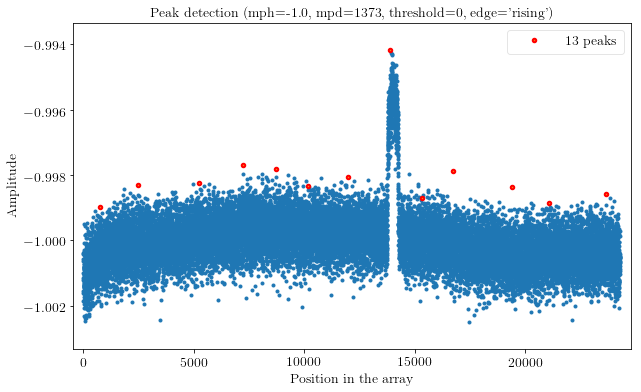

Text(0.5,0,'Time [days]')

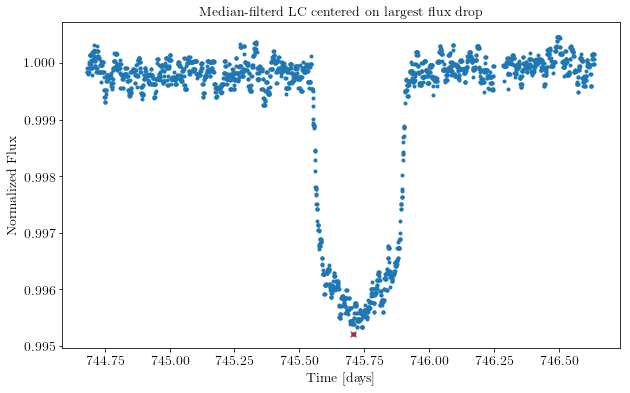

In [6]:
#KID5792202 = 5 planets

df = pd.read_csv(filename,sep='\t',index_col=None)
df.columns = ["time","flux","flux_err"]
x = df["time"]; y = df["flux"]; yerr = df["flux_err"]
print(len(x))

total_days = x.iloc[-1]-x.iloc[0]
one_day = int(len(x)/total_days) # len(x)/total_days corresponds to 1 day 

ind = detect_peaks(y*-1, mph=-1., mpd=one_day, show=True) #mpd: detect peaks that are at least separated by min peak distance (in number of data)
flux_peaks = y[ind]
time_max_peak = (flux_peaks).idxmin(axis=None, skipna=True)

dist_from_transit = int(one_day/1.)
y = sig.medfilt(y,13)
newX = (x[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]).values
newY = y[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]

time_max_peak = np.argmin(newY)
tc = newX[time_max_peak]

plt.figure(figsize=(10,6))
plt.plot(newX, newY, ".",tc, newY[time_max_peak],'xr'); 
plt.title('Median-filterd LC centered on largest flux drop')
plt.ylabel("Normalized Flux"); plt.xlabel("Time [days]")

The detrend function detrends the normalized flux with a median filter using the sig.medfilt module

In [7]:
def get_keyTimes(times, pre, post, offset, drop, ind_maxPeak):
    y1 = np.abs(pre-offset+0.35*drop)
    y2 = np.abs(pre-offset+0.65*drop)
    y3 = np.abs(post-offset+0.65*drop)
    y4 = np.abs(post-offset+0.35*drop)
    
    margin = 20
    res1 = times[np.argmin(y1)]
    res2 = times[np.argmin(y2)+margin]
    res3 = times[np.argmin(y3)+ind_maxPeak-margin]
    res4 = times[np.argmin(y4)+ind_maxPeak]
    
    return res1, res2, res3, res4

t1 = 745.56 days | t2 = 745.60 days | t3 = 745.87 days | t4 = 745.90


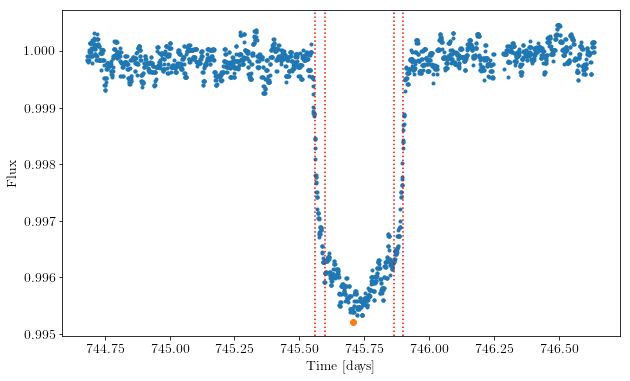

In [8]:
baseline = np.median(newY)
delta = np.median(newY)-newY[time_max_peak]

pre_tr = newY[:time_max_peak]
post_tr = newY[time_max_peak:]

t1,t2,t3,t4 = get_keyTimes(newX, pre_tr, post_tr, baseline, delta, time_max_peak)

print("t1 = {0:0.2f} days | t2 = {1:0.2f} days | t3 = {2:0.2f} days | t4 = {3:0.2f}".format(t1,t2,t3,t4))

xposition = [t1,t2,t3,t4]
plt.figure(figsize=(10,6))
plt.plot(newX, newY, ".",tc, newY[time_max_peak],'o')
plt.ylabel("Flux"); plt.xlabel("Time [days]")
for xc in xposition: plt.axvline(x=xc, color='r', linestyle='dotted')

In [9]:
tc = (((t3+t2)/2)+((t4+t1)/2))/2
width_trans = t3-t2
slope_trans = -delta/(t2-t1)
T = ((t4+t3)-(t2+t1))/2 #FWHM 
tau_avg = ((t2-t1)+(t4-t3))/2

print(tc,(t3+t2)/2, (t4+t1)/2)

745.7306195 745.7318115 745.7294274999999


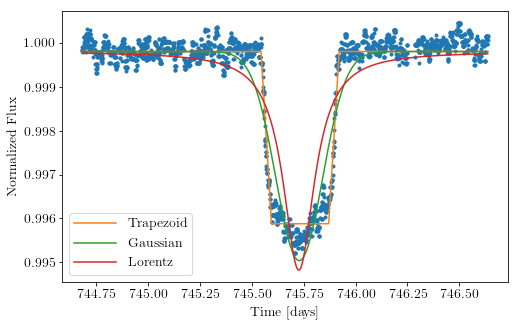

In [10]:
t_init = models.Trapezoid1D(amplitude=-delta, x_0=tc, 
                            width=width_trans, slope=slope_trans)
                           #fixed={'amplitude': True})

g_init = models.Gaussian1D(amplitude=-delta, mean=tc, stddev=T)
l_init = models.Lorentz1D(amplitude=-delta, x_0=tc, fwhm = T) 

fit_flux = fitting.LevMarLSQFitter()

t = fit_flux(t_init, newX, newY-baseline)
g = fit_flux(g_init, newX, newY-baseline)
l = fit_flux(l_init, newX, newY-baseline)

#Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(newX, newY, '.')
plt.plot(newX, t(newX)+baseline, label='Trapezoid')
plt.plot(newX, g(newX)+baseline, label='Gaussian')
plt.plot(newX, l(newX)+baseline, label='Lorentz')
plt.ylabel("Normalized Flux"); plt.xlabel("Time [days]")
plt.legend()

T = 0.32 days
tau = 0.05 days
delta = 0.00393
t1 = 745.55 , t2 = 745.59, t3 = 745.87 , t4 = 745.92 [days]


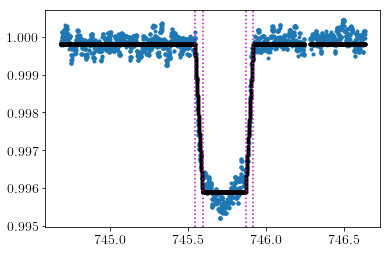

In [11]:
##THIS IS ONLY FOR TRAPEZOID MODEL
amp_fit, x0_fit, width_fit, slope_fit = t.parameters

delta_fit = amp_fit*-1
tc_fit = x0_fit

t1_fit = (delta_fit/slope_fit)+t2
t2_fit = (2.*tc_fit-width_fit)/2.
t3_fit = (2.*tc_fit+width_fit)/2.
t4_fit = 2*tc_fit-t1_fit

T_fit = ((t4_fit+t3_fit)-(t2_fit+t1_fit))/2 #FWHM 
tau_fit = ((t2_fit-t1_fit)+(t4_fit-t3_fit))/2

print("T = {0:0.2f} days\ntau = {1:0.2f} days\n\
delta = {2:0.5f}\nt1 = {3:0.2f} , t2 = {4:0.2f},\
 t3 = {5:0.2f} , t4 = {6:0.2f} [days]".format(T_fit, tau_fit,
                                               delta_fit, t1_fit, t2_fit,
                                               t3_fit,t4_fit))


tfits_position = [t1_fit,t2_fit,t3_fit,t4_fit]
plt.plot(newX, newY, '.')
plt.plot(newX, t(newX)+baseline, '.k', label='Trapezoid')
for xc in tfits_position: plt.axvline(x=xc, color='m', linestyle='dotted')

In [12]:
Q = 7.1
sigmaP_P = np.sqrt(1/Q**2 * (27*T_fit/2*tau_fit))
print(sigmaP_P)

0.06428468622423505


In [13]:
G = 6.676e-11  #Unit  = m3 / (kg s2)# Newton's constant in $R_\odot^3 M_\odot^{-1} {days}^{-2}$: G = 2945.4625385377644
srho_kgm3 = srho * 1000   #srho is originally given in g/cm3, but we convert it to kg/m3 
P = ((G*np.pi**2)/3)*srho_kgm3*(T_fit*tau_fit*86400**2/np.sqrt(delta_fit))**(3/2)
print(P/86400) #in days

45.58795870313806


Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0029357606492728555
            Iterations: 101
            Function evaluations: 1700
            Gradient evaluations: 101
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.000804456422284423
            Iterations: 3
            Function evaluations: 45
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00024173963356031075
            Iterations: 17
            Function evaluations: 291
            Gradient evaluations: 17


Text(0,0.5,'Flux')

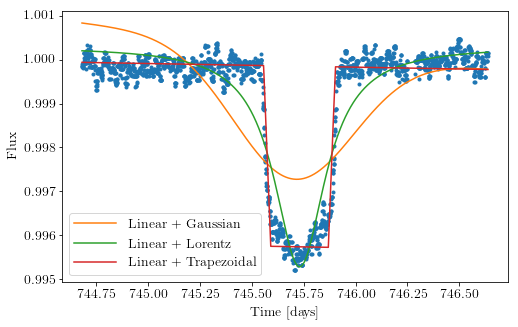

In [14]:
f0 = models.Linear1D(slope = 0.0, intercept = np.median(newY))
gau = models.Gaussian1D(amplitude=-delta, mean=tc, stddev=T)
loren = models.Lorentz1D(amplitude=-delta, x_0=tc, fwhm = T) 
trap = models.Trapezoid1D(amplitude=-delta, x_0=tc, width=t3-t2, slope=-delta/(t2-t1))

# Now to fit the data create a new superposition with initial guesses for the parameters:
LG_init = f0+gau
LL_init = f0+loren
LT_init = f0+trap

fit_flux = fitting.SLSQPLSQFitter()
LG_fit = fit_flux(LG_init, newX, newY);
LL_fit = fit_flux(LL_init, newX, newY);
LT_fit = fit_flux(LT_init, newX, newY);

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(newX, newY, '.')
plt.plot(newX, LG_fit(newX),label='Linear + Gaussian')
plt.plot(newX, LL_fit(newX),label='Linear + Lorentz')
plt.plot(newX, LT_fit(newX),label='Linear + Trapezoidal')
plt.legend(); plt.xlabel('Time [days]'); plt.ylabel('Flux')

In [15]:
import emcee
import corner

def lnprior(theta, args):
    minT, maxT = args
    delta, tc, width, slope = theta
    if 0.0 < delta < 0.2 and  (minT < tc < maxT) and (0.0 < width < (maxT-minT)) and (-1<slope<0.0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr = None):
    minT = min(x)
    maxT = max(x)
    lp = lnprior(theta, (minT, maxT))
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)
    #return lnlike(theta, x, y, yerr)

def lnlike(theta, x, y, yerr = None):
    delta, tc, width, slope = theta
    model = models.Trapezoid1D(amplitude=-delta, x_0=tc, 
                               width=width, slope=slope)
    
    #inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model(x))**2))

ndim, nwalkers = 4, 100
mc_guess = [delta, tc, t3-t2, -delta/(t2-t1)]

pos = [mc_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(newX, newY-np.median(newY)))

sampler.run_mcmc(pos, 500);

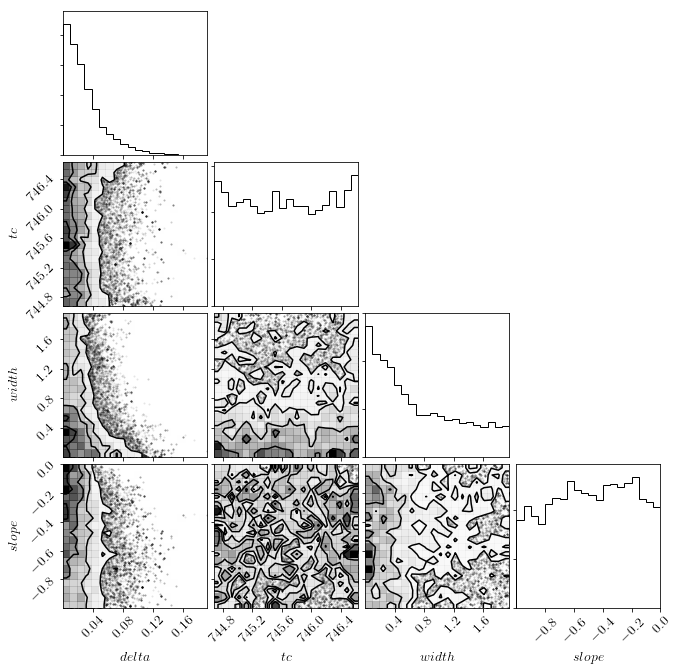

In [16]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

fig = corner.corner(samples, 
                    labels=["$delta$", "$tc$", "$width$", "$slope$"])

In [30]:
import vespa
sample_res = vespa.transit_basic.traptransit_MCMC(newX, newY, dfs=1e-05,
                                     nwalkers=200, nburn=300, niter=1000, 
                                     threads=1, p0=[0.1, 0.1, 3, 0], return_sampler=True, maxslope=30)

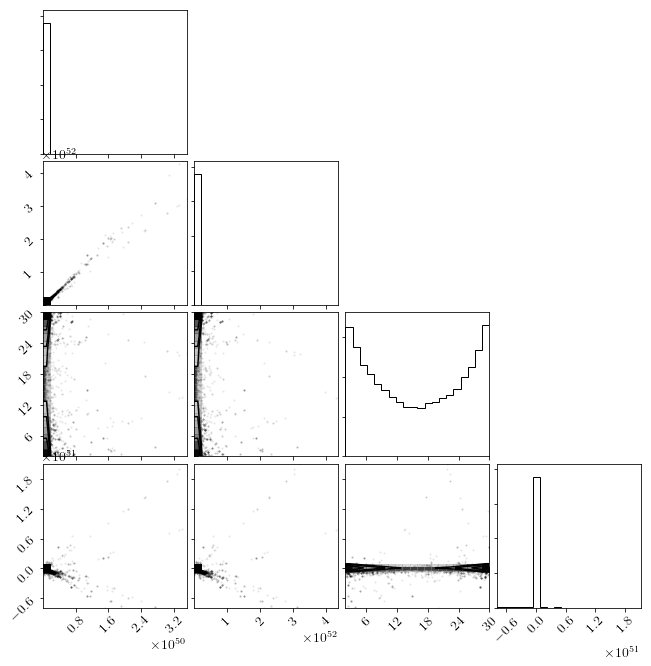

In [34]:
samples2 = sample_res.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples2)